In [21]:
import os

dataset_path = "/kaggle/input/swir-products-merged2/swir_products_merged2"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")

dataset_path_test = "/kaggle/input/swir-products-merged2/swir_products_merged2"
test_images_path = os.path.join(dataset_path_test, "images/test")
test_masks_path = os.path.join(dataset_path_test, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])


Train Images: 678
Train Masks: 226
Test Images: 108
Test Masks: 36

Примеры файлов (Train Images): ['349_1050.jpg', '122_800.jpg', '345_1050.jpg', '072_800.jpg', '107_800.jpg']
Примеры файлов (Train Masks): ['173.png', '248.png', '038.png', '069.png', '340.png']


In [22]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as T


class MultiChannelSingleMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, wavelengths=(800, 1050, 1550), transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.wavelengths = wavelengths
        self.transform = transform
        self.img_size = img_size

        # Собираем все файлы изображений и извлекаем уникальные ID
        all_files = os.listdir(images_dir)
        
        # Фильтруем только те файлы, которые являются изображениями
        image_ids = sorted(set(f.split('_')[0] for f in all_files if f.endswith(".jpg")))

        # Проверка, если нет файлов, то выводим ошибку
        if not image_ids:
            print(f"Нет файлов изображений в директории: {images_dir}")
        else:
            print(f"Найдены следующие ID изображений: {image_ids}")

        # Подготовим список ID изображений
        self.image_ids = image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Загружаем 3 изображения по длинам волн
        image = []
        for wl in self.wavelengths:
            image_path = os.path.join(self.images_dir, f"{image_id}_{wl}.jpg")
            if not os.path.exists(image_path):
                print(f"Изображение не найдено: {image_path}")
                continue  # Пропускаем файл, если его нет
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype(np.float32) / 255.0
            image.append(img)
        
        # Если не все каналы загружены, пропускаем этот ID
        if len(image) != len(self.wavelengths):
            print(f"Ошибка: не удалось загрузить все каналы для ID {image_id}")
            return None  # Если не удалось загрузить все каналы, возвращаем None

        image = np.stack(image, axis=-1)  # [H, W, 3]

        # Загружаем маску (одну для всех)
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")
        if not os.path.exists(mask_path):
            print(f"Маска не найдена: {mask_path}")
            return None  # Если маска не найдена, возвращаем None
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        
        # Ресайз маски до 512x512
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # Применяем аугментации, если есть
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # В PyTorch: [C, H, W]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [3, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # [H, W], где 0 — фон, 1 — дефект

        return image, mask




train_dataset = MultiChannelSingleMaskDataset(train_images_path, train_masks_path, img_size=512)

# Пробуем взять первый элемент:
sample_img, sample_mask = train_dataset[0]

if sample_img is not None and sample_mask is not None:
    print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
    print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
    print(f"Классы в маске: {torch.unique(sample_mask)}")
else:
    print("Ошибка при загрузке данных")


Найдены следующие ID изображений: ['034', '035', '036', '037', '038', '044', '047', '048', '049', '050', '051', '053', '054', '055', '056', '057', '058', '059', '060', '061', '063', '064', '065', '068', '069', '070', '072', '073', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '086', '087', '088', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '114', '115', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '131', '132', '133', '134', '136', '137', '138', '139', '141', '142', '143', '144', '145', '146', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '167', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199',

Размер датасета: 226
Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


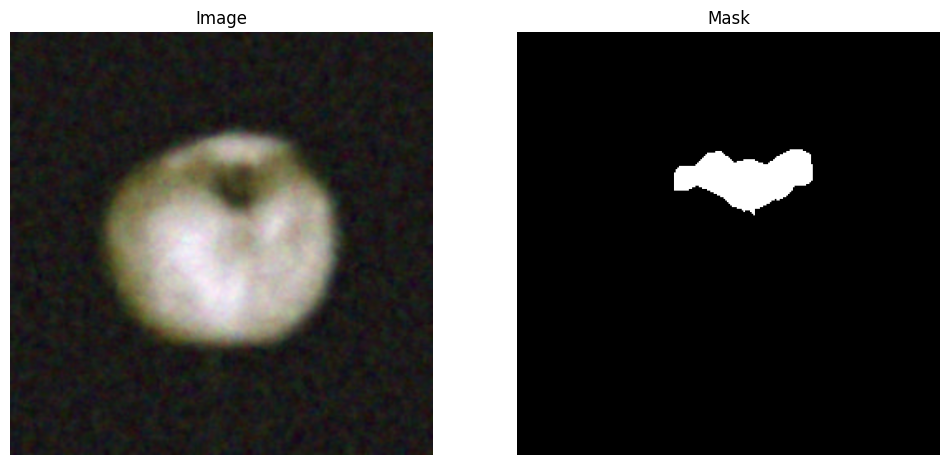

In [23]:
# 1. Проверим длину датасета
print(f"Размер датасета: {len(train_dataset)}")

# 2. Попробуем загрузить и вывести первое изображение и его маску
sample_img, sample_mask = train_dataset[217]

# Проверим, что изображение и маска загружены
if sample_img is not None and sample_mask is not None:
    print(f"Форма изображения: {sample_img.shape}")  # Ожидаем [3, 512, 512]
    print(f"Форма маски: {sample_mask.shape}")        # Ожидаем [512, 512]
    print(f"Классы в маске: {torch.unique(sample_mask)}")
else:
    print("Ошибка при загрузке данных")

# 3. Для визуализации одного примера
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    image = image.permute(1, 2, 0).numpy()  # Преобразуем изображение в [H, W, C]
    mask = mask.numpy()
    
    # Создаем подграфики для изображения и маски
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Отображаем изображение
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    # Отображаем маску
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.show()

# Отображаем первый пример
if sample_img is not None and sample_mask is not None:
    show_image_and_mask(sample_img, sample_mask)


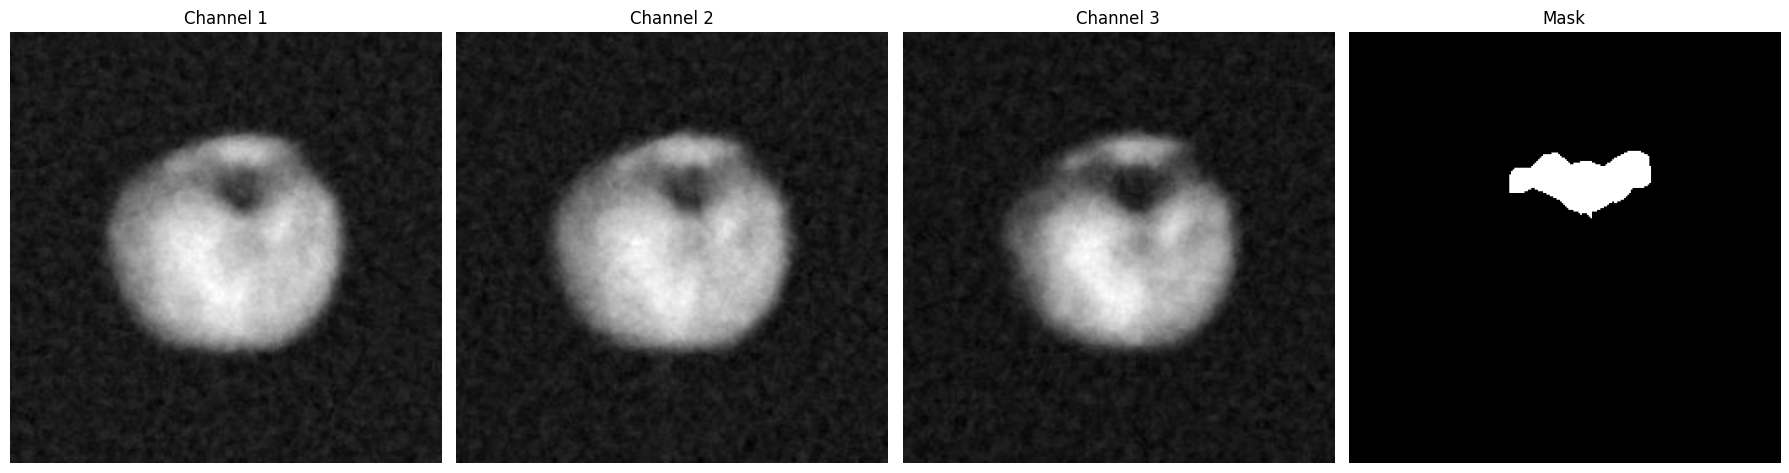

In [24]:
def show_individual_channels(image_tensor, mask_tensor):
    image = image_tensor.numpy()
    mask = mask_tensor.numpy()

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    for i in range(3):
        axes[i].imshow(image[i], cmap='gray')
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis('off')
    
    axes[3].imshow(mask, cmap='gray')
    axes[3].set_title("Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования:
show_individual_channels(sample_img, sample_mask)


In [25]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #, drop_last=True

batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]


Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [26]:
mask_files = sorted(os.listdir(train_masks_path))[:1]

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)

    print(f"Маска: {mask_file} → Уникальные классы: {np.unique(mask_array)}")

Маска: 034.png → Уникальные классы: [0 1]


In [27]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"Общее количество уникальных классов: {len(all_classes)}")
print(f"Уникальные классы: {sorted(all_classes)}")


Общее количество уникальных классов: 2
Уникальные классы: [0, 1]


In [28]:
print(len(all_classes))

2


In [29]:
import torch.nn as nn
import torchvision.models.segmentation as segmentation

model = segmentation.deeplabv3_resnet50(pretrained=True) #, aux_loss=True
num_classes = 2  # Включая класс фона
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("/kaggle/input/deeplabv3-50-gooddataset01-no-defects-finetuned/deeplabv3_resnet50-good-dataset-0-1(no-defects)-finetuned.pth"))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 234MB/s] 
/tmp/ipykernel_31/1820367373.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [30]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [31]:
# Замораживаем все слои модели, кроме классификаторов
for param in model.parameters():
    param.requires_grad = False

# Размораживаем последний блок и классификаторы (включая aux_classifier)
for param in model.classifier.parameters():
    param.requires_grad = True

# Размораживаем aux_classifier
for param in model.aux_classifier.parameters():
    param.requires_grad = True

# Заменяем последний слой на соответствующее количество классов
num_classes = 1  # Включая класс фона
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Обучается: {name}")
    else:
        print(f"Заморожено: {name}")



Заморожено: backbone.conv1.weight
Заморожено: backbone.bn1.weight
Заморожено: backbone.bn1.bias
Заморожено: backbone.layer1.0.conv1.weight
Заморожено: backbone.layer1.0.bn1.weight
Заморожено: backbone.layer1.0.bn1.bias
Заморожено: backbone.layer1.0.conv2.weight
Заморожено: backbone.layer1.0.bn2.weight
Заморожено: backbone.layer1.0.bn2.bias
Заморожено: backbone.layer1.0.conv3.weight
Заморожено: backbone.layer1.0.bn3.weight
Заморожено: backbone.layer1.0.bn3.bias
Заморожено: backbone.layer1.0.downsample.0.weight
Заморожено: backbone.layer1.0.downsample.1.weight
Заморожено: backbone.layer1.0.downsample.1.bias
Заморожено: backbone.layer1.1.conv1.weight
Заморожено: backbone.layer1.1.bn1.weight
Заморожено: backbone.layer1.1.bn1.bias
Заморожено: backbone.layer1.1.conv2.weight
Заморожено: backbone.layer1.1.bn2.weight
Заморожено: backbone.layer1.1.bn2.bias
Заморожено: backbone.layer1.1.conv3.weight
Заморожено: backbone.layer1.1.bn3.weight
Заморожено: backbone.layer1.1.bn3.bias
Заморожено: backbo

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [33]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

classifier.0.convs.0.0.weight разморожен
classifier.0.convs.0.1.weight разморожен
classifier.0.convs.0.1.bias разморожен
classifier.0.convs.1.0.weight разморожен
classifier.0.convs.1.1.weight разморожен
classifier.0.convs.1.1.bias разморожен
classifier.0.convs.2.0.weight разморожен
classifier.0.convs.2.1.weight разморожен
classifier.0.convs.2.1.bias разморожен
classifier.0.convs.3.0.weight разморожен
classifier.0.convs.3.1.weight разморожен
classifier.0.convs.3.1.bias разморожен
classifier.0.convs.4.1.weight разморожен
classifier.0.convs.4.2.weight разморожен
classifier.0.convs.4.2.bias разморожен
classifier.0.project.0.weight разморожен
classifier.0.project.1.weight разморожен
classifier.0.project.1.bias разморожен
classifier.1.weight разморожен
classifier.2.weight разморожен
classifier.2.bias разморожен
classifier.4.weight разморожен
classifier.4.bias разморожен
aux_classifier.0.weight разморожен
aux_classifier.1.weight разморожен
aux_classifier.1.bias разморожен
aux_classifier.4.wei

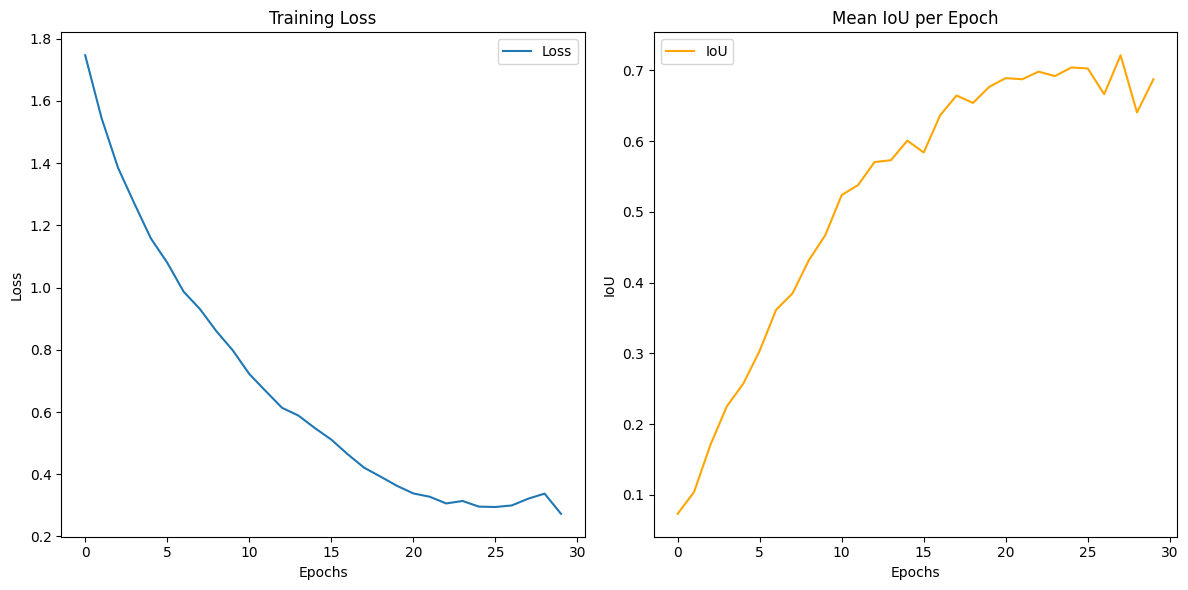

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# Предполагается, что модель теперь выдаёт [B, 1, H, W] без softmax, а просто логиты
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} разморожен")

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Потеря с учетом дисбаланса классов
# pos_weight увеличивает вклад класса 1 (дефектов)
criterion_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device))  # Подбери 10.0 под себя

# Функция для расчета IoU
def calculate_binary_iou(preds, labels, threshold=0.5):
    """
    Бинарный IoU (только один класс).
    """
    preds = torch.sigmoid(preds) > threshold  # logits -> probabilities -> binary
    preds = preds.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    labels = labels.bool()

    intersection = (preds & labels).sum(dim=(1, 2))
    union = (preds | labels).sum(dim=(1, 2))

    iou = intersection.float() / (union.float() + 1e-6)
    return iou.cpu().numpy()

# Tversky loss
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    """
    Tversky loss for binary segmentation.
    """
    smooth = 1e-6
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    true_pos = (y_true * y_pred).sum()
    false_neg = ((1 - y_true) * y_pred).sum()
    false_pos = (y_true * (1 - y_pred)).sum()

    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

# Focal loss
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal loss for binary classification.
    """
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    # Cross entropy loss
    ce_loss = F.binary_cross_entropy(torch.sigmoid(y_pred), y_true, reduction='none')

    # Focal loss modulating factor
    focal_modulating_factor = torch.pow(1 - torch.sigmoid(y_pred), gamma)

    # Apply modulating factor and weight the loss by alpha
    loss = alpha * focal_modulating_factor * ce_loss

    return loss.mean()

# Комбинированная потеря: BCE + Tversky + Focal loss
def combined_loss(y_true, y_pred,
                  lambda1=1.0, lambda2=1.0,
                  alpha_t=0.7, beta_t=0.3, gamma_t=1.33,
                  gamma_f=2.0, alpha_f=0.25):
    bce = criterion_bce(y_pred, y_true)
    focal = focal_loss(y_true, y_pred, gamma=gamma_f, alpha=alpha_f)
    tversky = tversky_loss(y_true, y_pred, alpha=alpha_t, beta=beta_t)

    # Формула: BCE * (1 + λ1 * Focal) + λ2 * (1 - Tversky)^γ
    loss = bce * (1 + lambda1 * focal) + lambda2 * torch.pow((1 - tversky), gamma_t)
    return loss

epochs = 30
all_losses = []
all_ious = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    iou_list = []

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device).float()  # [B, H, W] — значения 0.0 и 1.0

        optimizer.zero_grad()
        outputs = model(images)['out']  # [B, 1, H, W]

        # Расчёт комбинированной потери
        loss = combined_loss(masks.unsqueeze(1), outputs)  # Приведение: [B, H, W] -> [B, 1, H, W]
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        iou_batch = calculate_binary_iou(outputs, masks)
        iou_list.extend(iou_batch)

        if batch_idx % 10 == 0:
            print(f"Эпоха {epoch+1}/{epochs}, Итерация {batch_idx}/{len(train_loader)}, Потери: {running_loss/(batch_idx+1):.4f}")

    avg_loss = running_loss / len(train_loader)
    avg_iou = np.nanmean(iou_list)
    all_losses.append(avg_loss)
    all_ious.append(avg_iou)

    print(f"📉 Эпоха {epoch+1}/{epochs}, Средние потери: {avg_loss:.4f}, Средний IoU: {avg_iou:.4f}")

# Сохраняем веса модели
torch.save(model.state_dict(), "deeplabv3_binary.pth")

# Визуализация
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(epochs), all_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# График IoU
plt.subplot(1, 2, 2)
plt.plot(range(epochs), all_ious, label='IoU', color='orange')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Mean IoU per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
BATCH_SIZE = 8
NUM_WORKERS = 2
test_dataset = MultiChannelSingleMaskDataset(test_images_path, test_masks_path, img_size=512)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS) #, drop_last=True, shuffle=True

Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']


In [36]:
from sklearn.metrics import average_precision_score

def calculate_metrics_binary(preds, labels):
    """
    Вычисляет IoU, Dice и AP только по классу 1 (дефект).
    """
    preds = (torch.sigmoid(preds) > 0.5).float()  # Binarize: [B, 1, H, W]
    preds = preds.squeeze(1)
    labels = labels.squeeze(1)

    intersection = ((preds == 1) & (labels == 1)).sum(dim=(1, 2)).float()
    union = ((preds == 1) | (labels == 1)).sum(dim=(1, 2)).float()
    dice = (2 * intersection) / ((preds == 1).sum(dim=(1, 2)).float() + (labels == 1).sum(dim=(1, 2)).float() + 1e-8)
    iou = intersection / (union + 1e-8)

    # mAP по пикселям: flatten predictions and targets
    aps = []
    for i in range(preds.shape[0]):
        pred_flat = torch.sigmoid(preds[i].unsqueeze(0)).flatten().cpu().numpy()
        label_flat = labels[i].flatten().cpu().numpy()
        if label_flat.sum() > 0:
            ap = average_precision_score(label_flat, pred_flat)
            aps.append(ap)

    return iou.mean().item(), dice.mean().item(), np.mean(aps) if aps else float('nan')


In [37]:
ious, dices, maps = [], [], []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        outputs = model(images)['out']
        iou, dice, ap = calculate_metrics_binary(outputs, masks)

        if not np.isnan(iou):
            ious.append(iou)
        if not np.isnan(dice):
            dices.append(dice)
        if not np.isnan(ap):
            maps.append(ap)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
mean_ap = np.mean(maps)

print(f"📐 IoU (defect): {mean_iou:.4f}")
print(f"❤️ Dice (defect): {mean_dice:.4f}")
print(f"🏅 mAP (defect): {mean_ap:.4f}")


📐 IoU (defect): 0.4722
❤️ Dice (defect): 0.5999
🏅 mAP (defect): 0.4612


In [38]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    if len(mask.shape) == 3:
        mask = mask.squeeze()  # [1, H, W] → [H, W]
    
    colored_mask = np.zeros_like(image)
    for i in range(3):
        colored_mask[:, :, i] = mask * color[i]
    
    overlay = cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)
    return overlay

def visualize_predictions(test_loader, predictions, num_samples=10):
    predictions = [pred.squeeze().cpu().numpy() if torch.is_tensor(pred) else pred for pred in predictions]
    samples = random.sample(range(len(predictions)), num_samples)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        mask = mask.numpy().squeeze()
        pred_mask = predictions[idx]

        # Ensure masks are 2D
        if pred_mask.ndim > 2:
            pred_mask = pred_mask.squeeze()
        if mask.ndim > 2:
            mask = mask.squeeze()

        # Binarize predicted mask (assuming values in [0, 1])
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        mask_binary = (mask > 0.5).astype(np.uint8)

        # Apply mask overlays
        overlay_pred = apply_mask((image * 255).astype(np.uint8), pred_binary, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask((image * 255).astype(np.uint8), mask_binary, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Original")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Overlay")
        
        axes[i, 3].imshow(pred_binary, cmap='jet')
        axes[i, 3].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


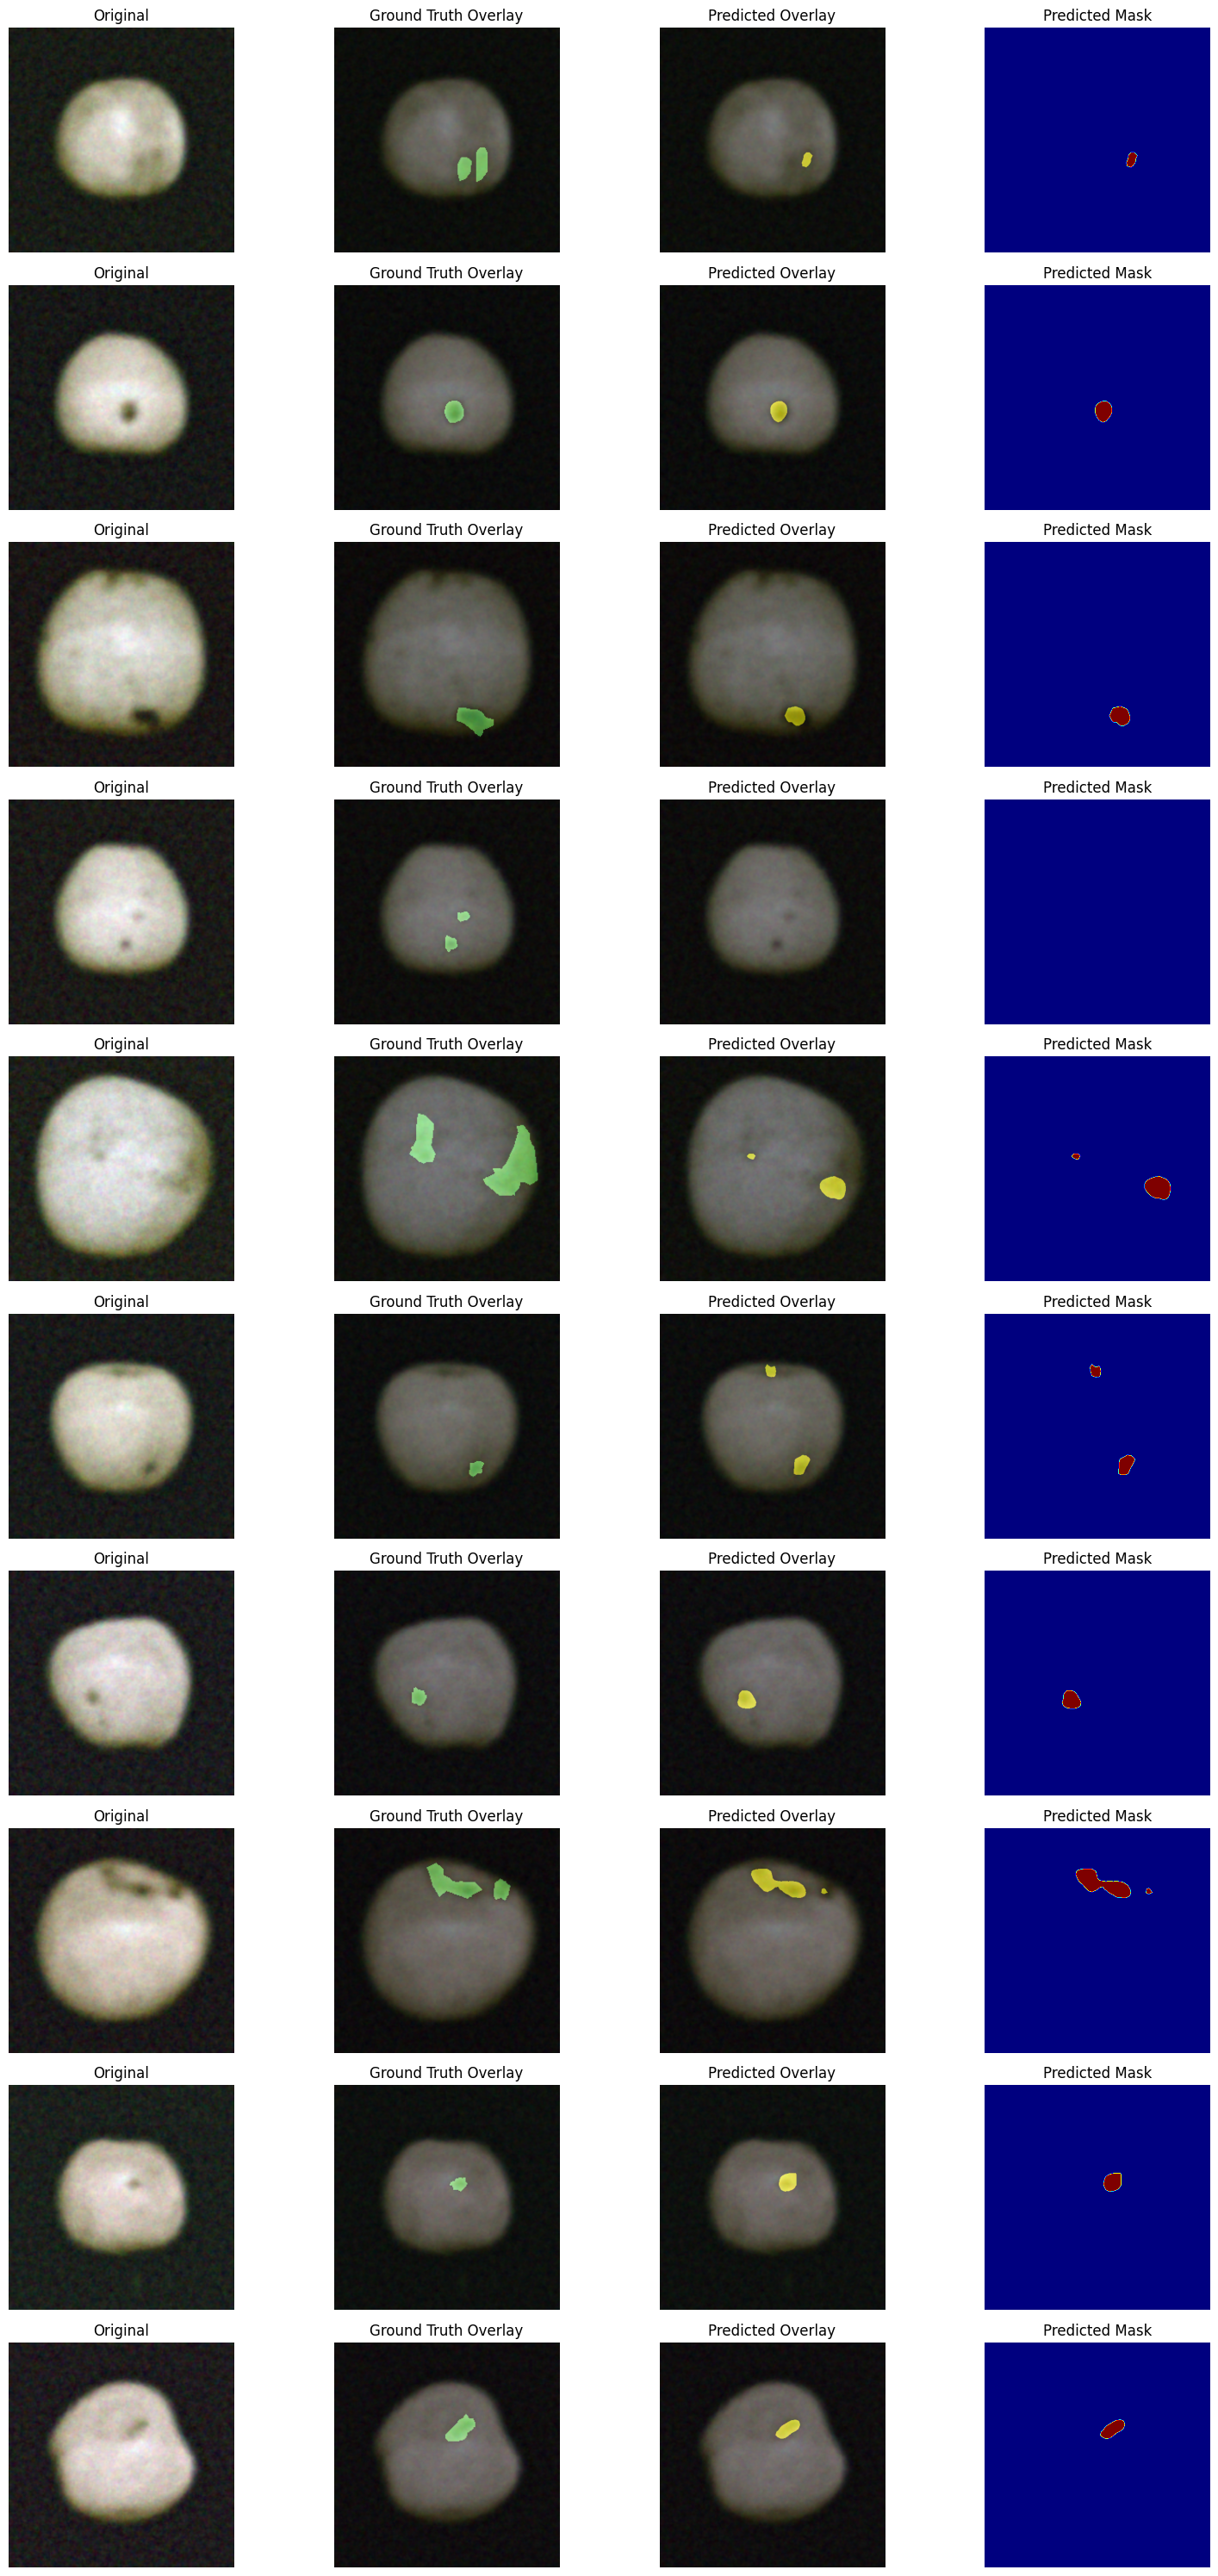

In [39]:
# Генерация масок для всего test_loader
model.eval()
predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)['out']
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu()
        predictions.extend(preds)

visualize_predictions(test_loader, predictions, num_samples=10)


In [42]:
import random
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate

def generate_random_tta():
    return Compose([
        HorizontalFlip(p=random.choice([0.0, 1.0])),
        VerticalFlip(p=random.choice([0.0, 1.0])),
    ])

In [44]:
tta_datasets = []

for i in range(5):
    tta_transform = generate_random_tta()
    dataset = MultiChannelSingleMaskDataset(
        test_images_path,
        test_masks_path,
        img_size=512,
        transform=tta_transform
    )
    tta_datasets.append(dataset)

Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031',

In [45]:
from torch.utils.data import DataLoader
import numpy as np

all_ious, all_dices, all_maps = [], [], []

model.eval()
with torch.no_grad():
    for idx, dataset in enumerate(tta_datasets):
        print(f"🔄 TTA iteration {idx + 1}/10")
        loader = DataLoader(dataset, batch_size=4, num_workers=4)

        ious, dices, maps = [], [], []

        for images, masks in loader:
            if images is None or masks is None:
                continue  # Пропускаем битые данные
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)['out']
            iou, dice, ap = calculate_metrics_binary(outputs, masks)

            if not np.isnan(iou):
                ious.append(iou)
            if not np.isnan(dice):
                dices.append(dice)
            if not np.isnan(ap):
                maps.append(ap)

        all_ious.append(np.mean(ious))
        all_dices.append(np.mean(dices))
        all_maps.append(np.mean(maps))

# 📊 Финальная статистика
mean_iou = np.mean(all_ious)
mean_dice = np.mean(all_dices)
mean_ap = np.mean(all_maps)

std_iou = np.std(all_ious)
std_dice = np.std(all_dices)
std_ap = np.std(all_maps)

print("\n📈 Aggregated metrics over 10 TTA runs:")
print(f"📐 IoU (defect): {mean_iou:.4f} ± {std_iou:.4f}")
print(f"❤️ Dice (defect): {mean_dice:.4f} ± {std_dice:.4f}")
print(f"🏅 mAP (defect): {mean_ap:.4f} ± {std_ap:.4f}")


🔄 TTA iteration 1/10
🔄 TTA iteration 2/10
🔄 TTA iteration 3/10
🔄 TTA iteration 4/10
🔄 TTA iteration 5/10

📈 Aggregated metrics over 10 TTA runs:
📐 IoU (defect): 0.4408 ± 0.0281
❤️ Dice (defect): 0.5625 ± 0.0320
🏅 mAP (defect): 0.4327 ± 0.0277
